## Step 0 - Visualization

In [8]:
import os
import librosa
import librosa.display

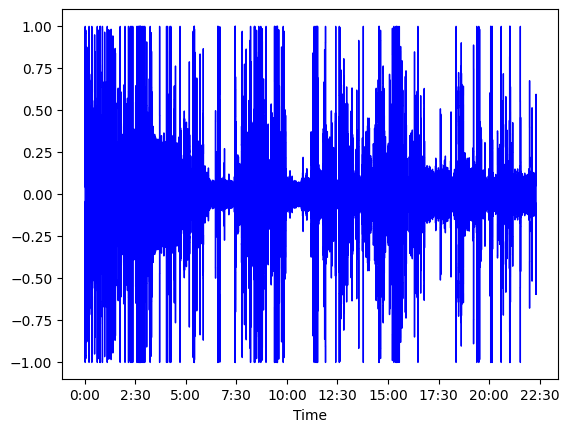

In [9]:
# Waveform by librosa
file ='audio.wav'
assert os.path.isfile(file)

wav, sr = librosa.load(file, sr=16000)
librosa.display.waveshow(wav,sr=sr, color='b')

## Step 1 - Noice cancellation

In [2]:
from scipy.io import wavfile
import noisereduce as nr

In [5]:
file ='audio.wav'
assert os.path.isfile(file)

rate, data = wavfile.read(file)

In [6]:
reduced_noise = nr.reduce_noise(y=data, sr=rate)
wavfile.write("step1.wav", rate, reduced_noise)

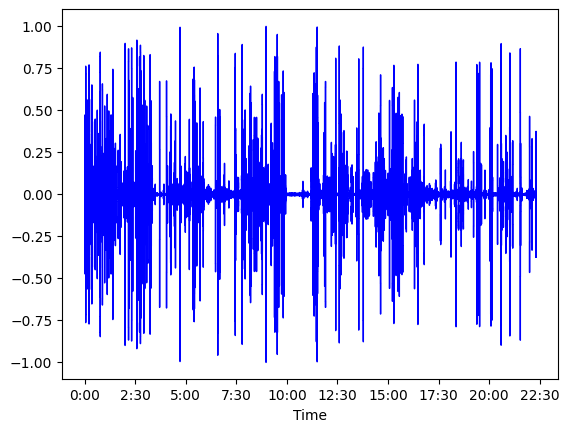

In [10]:
file ='step1.wav'
assert os.path.isfile(file)

wav, sr = librosa.load(file, sr=16000)
librosa.display.waveshow(wav,sr=sr, color='b')

## Step 2 - Slice slient parts

In [11]:
# To slice silent
from pyAudioAnalysis import audioBasicIO as aIO
from pyAudioAnalysis import audioSegmentation as aS
# To save audios
from pydub import AudioSegment
# To create metadata
import json

### Detect silence

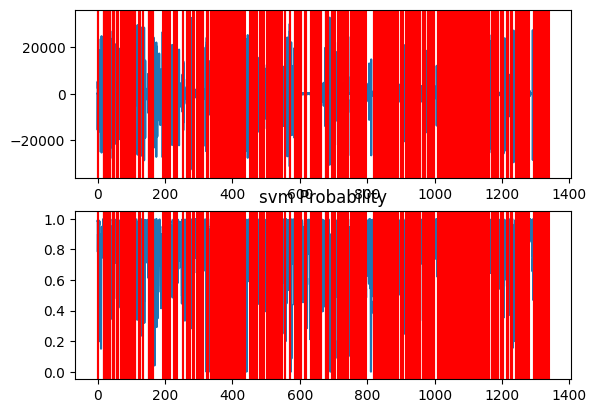

In [39]:
file = 'step1.wav'

assert os.path.isfile(file)

# below method returns the active / non silent segments of the audio file 
[Fs, x] = aIO.read_audio_file(file)
segments = aS.silence_removal(x, 
                             Fs, 
                             0.050, 
                             0.050, 
                             smooth_window=1.0, 
                             weight=1.0, 
                             plot=True)

### Remove too short windows

In [44]:
MIN_LENGTH, MIN_INTERVAL = 1.5, 3
START, END = 0, 1
modified_segments = [segment for segment in segments if segment[END] - segment[START] > MIN_LENGTH]
print(len(segments))
print(len(modified_segments))

combined_segments = [modified_segments[0][:]]
index = 1
while index < len(modified_segments):
    if modified_segments[index][START]-combined_segments[-1][END] > MIN_INTERVAL:
        combined_segments.append(modified_segments[index])
    else:
        combined_segments[-1][END] = modified_segments[index][END]
    index += 1

print(combined_segments, len(combined_segments))

271
51
[[88.05000000000001, 93.05000000000001], [213.10000000000002, 215.45000000000002], [283.45, 285.65000000000003], [337.25, 342.3], [350.55, 353.1], [364.15000000000003, 366.5], [376.45000000000005, 380.40000000000003], [398.8, 405.40000000000003], [416.90000000000003, 421.15000000000003], [435.25, 437.45000000000005], [452.1, 456.20000000000005], [481.85, 485.8], [501.6, 504.95000000000005], [508.6, 512.8000000000001], [527.85, 529.4], [534.85, 543.9], [635.6, 637.3000000000001], [640.9000000000001, 647.4000000000001], [733.6500000000001, 735.75], [769.3000000000001, 771.45], [775.95, 779.6500000000001], [785.0, 786.6500000000001], [789.75, 794.9000000000001], [841.3000000000001, 844.25], [880.7, 886.3000000000001], [901.1, 902.8000000000001], [921.9000000000001, 923.6], [927.7, 940.95], [965.45, 967.0500000000001], [1015.8000000000001, 1023.9000000000001], [1074.7, 1076.7], [1115.0, 1122.8], [1126.95, 1136.9], [1140.65, 1146.5], [1153.7, 1157.0], [1169.4, 1171.1000000000001], [1

### Slice silent windows

In [45]:
myaudio = AudioSegment.from_wav(file)
if combined_segments:
    for index, segment in enumerate(combined_segments):
        extract = myaudio[segment[START]*1000:segment[END]*1000]
        extract.export(f'step2-{index}.wav', format="wav")

### Create audio metadata

In [47]:
metadata = [{ 'num': index, 'start_sec': segment[0], 'end_sec': segment[1] } for index, segment in enumerate(combined_segments)]
json_object = json.dumps(metadata, indent=4)
 
# Writing to sample.json
with open("audio_metadata.json", "w") as outfile:
    outfile.write(json_object)

## Step 3 - Check if speaking or randome sound

In [25]:
# Figure out some how. currently human work.
# randome sound -> 0, 1, 2, 4, 5, 6, 7, 12, 14, 15, 16, 17, 18, 21, 22, 28
# speaking -> 0, 26, 28, 31, 

## Step 4 - Add silent part

### Caluclate total length

In [82]:
from datetime import datetime
import json
import math
import wave

In [83]:
TIMELAPSE_RATE = 30

In [84]:
path = '240405124608_metadata.json'

assert os.path.isfile(path)

with open(path, 'r') as file:
    data = json.load(file)
    start_time_string = ''.join(['20', data['start_time']])
    end_time_string = ''.join(['20', data['end_time']])

start_date = datetime.strptime(start_time_string, '%Y%m%d%H%M%S')
end_date = datetime.strptime(end_time_string, '%Y%m%d%H%M%S')

length = (end_date - start_date).seconds
silent_total = length / TIMELAPSE_RATE

### Calucate intervals between audios

In [105]:
path = 'audio_metadata.json'

assert os.path.isfile(path)

with open(path, 'r') as file:
    data = json.load(file)

START_KEY = 'start_sec'
intervals = [data[0][START_KEY]]
for i in range(len(data)-1):
    intervals.append(data[i+1][START_KEY] - data[i][START_KEY])

intervals.append(length - data[-1][START_KEY])
print('Original silent length:', intervals)

intervals[:] = [interval/TIMELAPSE_RATE for interval in intervals]
print('Timelapse slient length:', intervals)

assert math.isclose(sum(intervals), silent_total)


Original silent length: [88.05000000000001, 833.8500000000001, 43.549999999999955, 149.54999999999995, 224.0]
Timelapse slient length: [2.9350000000000005, 27.795000000000005, 1.451666666666665, 4.9849999999999985, 7.466666666666667]


### Generate one audio file

In [87]:
current = AudioSegment.silent(duration=intervals[0]*1000)

for i in range(1, len(intervals)):
    non_silence = AudioSegment.from_file(f'step3-{i-1}.wav')
    current = current.append(non_silence)

    interval = intervals[i]
    silence = AudioSegment.silent(duration=interval*1000)
    current = current.append(silence)

current.export('step4.wav', format="wav")

<_io.BufferedRandom name='step4.wav'>

## Step 5 - Generate interaction JSON

In [107]:
audio_length = []
for metadata in data:
    audio_length.append(metadata['end_sec'] - metadata['start_sec'])
print('Audio length:', audio_length)

pause_times = [metadata[START_KEY]/TIMELAPSE_RATE for metadata in data]
print('[Pause time]:', pause_times)

start_times = [time + length for time, length in zip(pause_times, audio_length)]
print('[Start time]:', start_times)

delta = [{} for _ in range(len(intervals)-1)]
delta[0]['pause_delta'] = pause_times[0]
delta[0]['start_delte'] = start_times[0]
for i in range(1, len(intervals)-1):
    delta[i]['pause_delta'] = sum(audio_length[:i+1]) + pause_times[i]
    delta[i]['start_delta'] = sum(audio_length[:i+1]) + start_times[i]
print('[Delta]:', delta)

Audio length: [5.0, 1.6999999999999318, 1.6000000000000227, 7.7999999999999545]
[Pause time]: [2.9350000000000005, 30.730000000000004, 32.181666666666665, 37.166666666666664]
[Start time]: [7.9350000000000005, 32.429999999999936, 33.78166666666669, 44.96666666666662]
[Delta]: [{'pause_delta': 2.9350000000000005, 'start_delte': 7.9350000000000005}, {'pause_delta': 37.429999999999936, 'start_delta': 39.12999999999987}, {'pause_delta': 40.48166666666662, 'start_delta': 42.08166666666664}, {'pause_delta': 53.26666666666657, 'start_delta': 61.06666666666653}]
